<a href="https://colab.research.google.com/github/m-njera/crop_disease/blob/master/Xception_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir = '/content/drive/My Drive/crop/'
train_data_dir = os.path.join(base_dir,'train')

image_width = 331
image_height = 331
batch_size=8

datagen = ImageDataGenerator(rescale=1./255,                                    
                                    
                                    zoom_range = 0.3,
                                    
                                    validation_split=0.20)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width,image_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode = 'categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width,image_height),
    shuffle=False,
    batch_size=batch_size,
    class_mode = 'categorical',
    subset='validation'
)


Found 702 images belonging to 3 classes.
Found 174 images belonging to 3 classes.


In [0]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (331, 331, 3), name = 'Image_input')

## The RESNET model

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception


#Get the RESNET weights and layers

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (331,331,3))
#model_xception_conv.summary()

In [0]:
#Use the generated model 
basic_model = Xception(include_top=False, weights='imagenet', pooling='avg')

# for layer in basic_model.layers:
#     layer.trainable = False

input_tensor = basic_model.input
# build top
x = basic_model.output
x = Dropout(.5)(x)
x = Dense(3, activation='softmax')(x)

xception_pretrained = Model(inputs=input_tensor, outputs=x)
#xception_pretrained.compile(optimizer=optimizers.RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


# # Compile CNN model
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
# sgd = optimizers.SGD(lr = 0.005)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint('xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)



# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(train_generator,steps_per_epoch = 614 / 8, callbacks=[checkpointer, earlystopper],
                                                            epochs = 50, verbose = 1, validation_data = validation_generator,validation_steps = 174/8)


Epoch 1/50
77/76 [==============================] - 116s 2s/step - loss: 1.1142 - acc: 0.3674 - val_loss: 1.0499 - val_acc: 0.4138

Epoch 00001: val_loss improved from inf to 1.04994, saving model to xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5
Epoch 2/50
77/76 [==============================] - 85s 1s/step - loss: 1.1088 - acc: 0.3777 - val_loss: 1.0489 - val_acc: 0.3621

Epoch 00002: val_loss improved from 1.04994 to 1.04893, saving model to xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5
Epoch 3/50
77/76 [==============================] - 91s 1s/step - loss: 1.0859 - acc: 0.4221 - val_loss: 1.0622 - val_acc: 0.3391

Epoch 00003: val_loss did not improve from 1.04893
Epoch 4/50
77/76 [==============================] - 90s 1s/step - loss: 1.1121 - acc: 0.4578 - val_loss: 1.0566 - val_acc: 0.4023

Epoch 00004: val_loss did not improve from 1.04893
Epoch 5/50
77/76 [==============================] - 90s 1s/step - loss: 1.0775 - acc: 0.4123 - val_loss: 1.0543 - val_acc

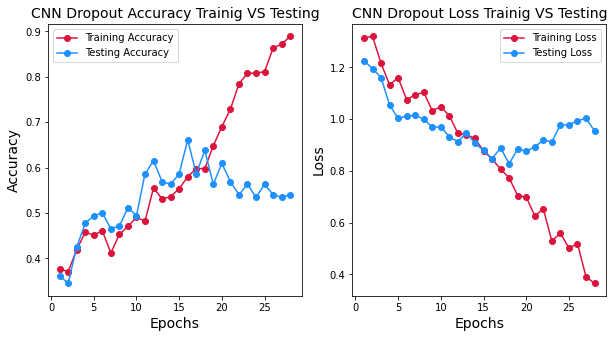

In [0]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(xception_pretrained.history.history['acc']) + 1), xception_pretrained.history.history['acc'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_acc']) + 1), xception_pretrained.history.history['val_acc'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint('xception_weights_no_shuffle.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1)



# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(train_generator,steps_per_epoch = 702 / 8, callbacks=[checkpointer, earlystopper],
                                                            epochs = 30, verbose = 1, validation_data = validation_generator,validation_steps=174/8)


Epoch 1/30
77/76 [==============================] - 156s 2s/step - loss: 1.2624 - acc: 0.3739 - val_loss: 1.2394 - val_acc: 0.4008

Epoch 00001: val_loss improved from inf to 1.23935, saving model to xception_weights_no_shuffle.hdf5
Epoch 2/30
77/76 [==============================] - 132s 2s/step - loss: 1.1870 - acc: 0.4199 - val_loss: 1.1935 - val_acc: 0.3817

Epoch 00002: val_loss improved from 1.23935 to 1.19353, saving model to xception_weights_no_shuffle.hdf5
Epoch 3/30
77/76 [==============================] - 138s 2s/step - loss: 1.1996 - acc: 0.3647 - val_loss: 1.0846 - val_acc: 0.4542

Epoch 00003: val_loss improved from 1.19353 to 1.08457, saving model to xception_weights_no_shuffle.hdf5
Epoch 4/30
77/76 [==============================] - 136s 2s/step - loss: 1.1435 - acc: 0.4080 - val_loss: 1.0391 - val_acc: 0.4313

Epoch 00004: val_loss improved from 1.08457 to 1.03907, saving model to xception_weights_no_shuffle.hdf5
Epoch 5/30
77/76 [==============================] - 134s

In [0]:
for k in sample.ID:
    ind=0
    print(f'treatment for {k}')
    testt=Image.open(glob.glob(f'./data/test/{k}.*')[0]).resize(IMAGE_SHAPE)
    testt=np.array(testt)/225
#     train_image_generator_all.fit(np.array(testt)[np.newaxis, ...])
    predict=model.predict(testt[np.newaxis, ...]).reshape(-1,)
#     predict=model.predict(next(train_image_generator_all.flow(np.array(testt)[np.newaxis, ...]))).reshape(-1,)
#     while len([m for m in predict if m>0.49])==0 and ind<10:
#         ind+=1
#         print('retraitment')
#         predict=model.predict(next(train_image_generator_all.flow(np.array(testt)[np.newaxis, ...]))).reshape(-1,)
        
     
    sample.loc[sample.ID==k,'healthy_wheat']=predict[0]
    sample.loc[sample.ID==k,'leaf_rust']=predict[1]
    sample.loc[sample.ID==k,'stem_rust']=predict[2]
sample